In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pathlib import Path
from func import np, f1_score_cal
import sys
sys.path.extend([str(Path.home() / "PycharmProjects/data_toolkit")])

from nlp.string_matching.function import run_match


def clean_text(text):
    return str(text).lower().strip()

cpu


In [20]:
path = Path.home() / 'OneDrive - Seagroup/computer_vison/shopee_item_images/'

# input
df = pd.read_csv(path / 'train.csv')

# clean
group_dicts = df.groupby('label_group')["posting_id"].apply(set).apply(list).to_dict()
df['target'] = df["label_group"].map(group_dicts)
df['title_edit'] = df['title'].map(clean_text)

df.head()

,posting_id,image,image_phash,title,label_group,target,title_edit
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794,"[train_2278313361, train_129225211]",paper bag victoria secret
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045,"[train_3386243561, train_3423213080]","double tape 3m vhb 12 mm x 4,5 m original / do..."
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891,"[train_2288590299, train_3803689425]",maling tts canned pork luncheon meat 397 gr
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,4093212188,"[train_2406599165, train_3342059966]",daster batik lengan pendek - motif acak / camp...
4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,3648931069,"[train_921438619, train_3369186413]",nescafe \xc3\x89clair latte 220ml


In [10]:
item = df['title_edit'].unique().tolist()
target_check = df['target'].tolist()

# find thresholds
thresholds = list(np.arange(0.4, 1, 0.1))
scores, plot_check, f1_score_lst, pred_lst = {}, {}, [], {}
for thres in thresholds:
    num = round(thres, 1)
    
    # run
    match_df = run_match(base=item, source=item, top=10, similarity=num)
    match_df['rank'] = match_df.groupby(['base'])['source'].transform(lambda x: pd.factorize(x)[0]).add(1)
    match_df = match_df.merge(df[['posting_id', 'title_edit']], how='left', left_on='base', right_on='title_edit')
    match_df = match_df.merge(df[['posting_id', 'title_edit']], how='left', left_on='source', right_on='title_edit', suffixes=('_base', '_source'))

    pred = match_df.groupby('posting_id_base')['posting_id_source'].apply(set).apply(list).to_dict()
    pred_check = df['posting_id'].map(pred).tolist()
    f1_score_lst = [f1_score_cal(i, v) for i, v in zip(target_check, pred_check)]
    
    score = np.mean(f1_score_lst)
    scores.update({num: score})
    plot_check.update({num: f1_score_lst})
    pred_lst.update({num: pred_check})
    print(f'--- F1 score for threshold {num} is {score:.3f} ---\n')
    
# choose thresholds 
best_score = max(scores, key=scores.get)
print(f'--- Best score is {round(scores[best_score], 4)} and has a threshold {best_score} ---')
df['text_pred'] = pred_lst[best_score]
df['f1_score'] = plot_check[best_score]

--- Best score is 0.6365 and has a threshold 0.6 ---


Text(0, 0.5, '')

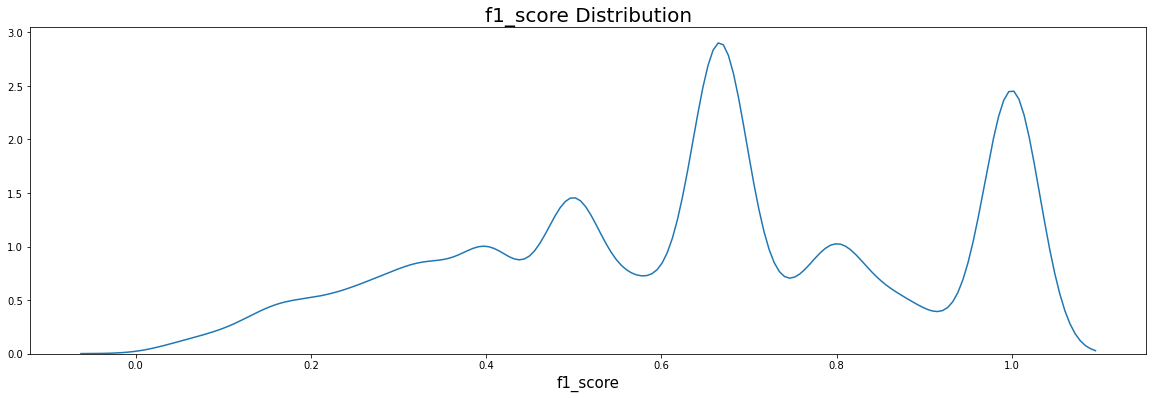

In [11]:
plt.figure(figsize=(20, 6))

plot = sns.kdeplot(x=df["f1_score"])
plt.title("f1_score Distribution", fontsize=20)
plt.xlabel("f1_score", fontsize=15)
plt.ylabel("")

In [ ]:
df.head()